# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### Constants

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
active_region_parameter = os.environ.get("RADARCOVID_REPORT__ACTIVE_REGION")
if active_region_parameter:
    active_region_country_code, active_region_country_name = \
        active_region_parameter.split(":")
else:
    active_region_country_code, active_region_country_name = \
        spain_region_country_code, spain_region_country_name

### COVID-19 Cases

In [5]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {active_region_country_name}

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
confirmed_df = confirmed_df[pd.isna(confirmed_df.Region)]
confirmed_df.head()

,Country_EN,Country_ES,Country_IT,Region,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21
233,Spain,España,Spagna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,888968.0,896086.0,908056.0,921374.0,936560.0,936560.0,936560.0,974449.0,988322.0,1005295.0


In [6]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,888968.0,896086.0,908056.0,921374.0,936560.0,936560.0,936560.0,974449.0,988322.0,1005295.0


In [7]:
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-10-17,936560.0
2020-10-18,936560.0
2020-10-19,974449.0
2020-10-20,988322.0
2020-10-21,1005295.0


In [8]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
268,2020-10-17,936560.0,0.0,10778.0
269,2020-10-18,936560.0,0.0,10778.0
270,2020-10-19,974449.0,37889.0,12212.0
271,2020-10-20,988322.0,13873.0,13177.0
272,2020-10-21,1005295.0,16973.0,13891.0


In [9]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.covid_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)

confirmed_df["covid_cases"] = confirmed_df.covid_cases.fillna(0).astype(int)
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
269,2020-10-18,936560.0,0.0,10778
270,2020-10-19,974449.0,37889.0,12212
271,2020-10-20,988322.0,13873.0,13177
272,2020-10-21,1005295.0,16973.0,13891
272,2020-10-22,1019186.0,13891.0,13891


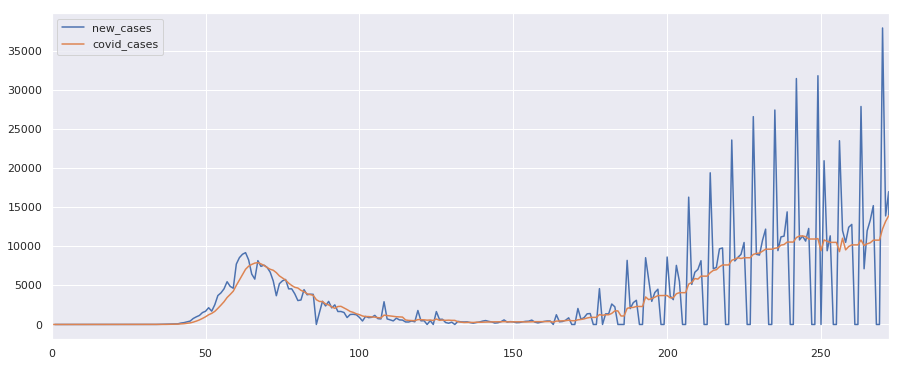

In [10]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [11]:
from Modules.ExposureNotification import exposure_notification_io

raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [active_region_country_code]
multi_region_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_region_exposure_keys_df["region"] = multi_region_exposure_keys_df["backend_identifier"]
multi_region_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_region_exposure_keys_df.head()

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/ES/index


Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/IE/index


Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 87, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/DE/index


,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-10-22,2020-10-22,ES,V1,214,1.2.840.10045.4.3.2,2c058c86-ee30-e1ec-261b-9f2e41ddc421,2672208,11,0,ES
0,2020-10-21,2020-10-21,ES,V1,214,1.2.840.10045.4.3.2,b29996ae-320e-1728-0d6a-5988db3eefca,2672064,144,0,ES
1,2020-10-21,2020-10-21,ES,V1,214,1.2.840.10045.4.3.2,e86045cc-038e-4087-a8e2-dbafb70dccad,2672064,144,0,ES
2,2020-10-21,2020-10-21,ES,V1,214,1.2.840.10045.4.3.2,84f5f784-4a1c-ad30-79b7-4ba6ddacc952,2672064,144,0,ES
3,2020-10-21,2020-10-21,ES,V1,214,1.2.840.10045.4.3.2,2fc6e472-13e8-d7ba-3ecd-603964ef35cd,2672064,144,0,ES


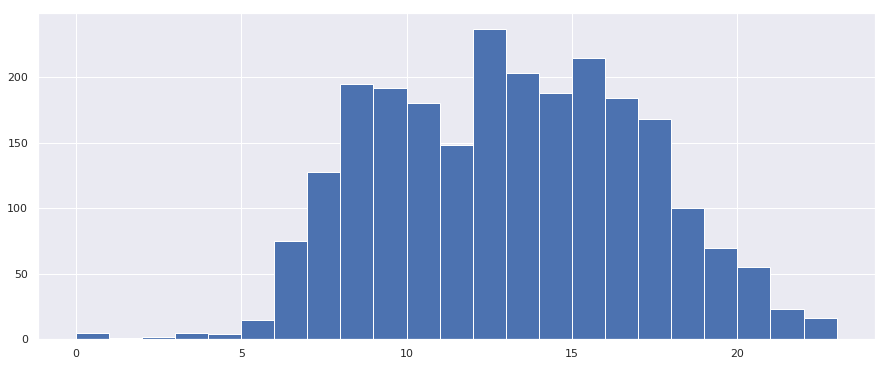

In [12]:
early_teks_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

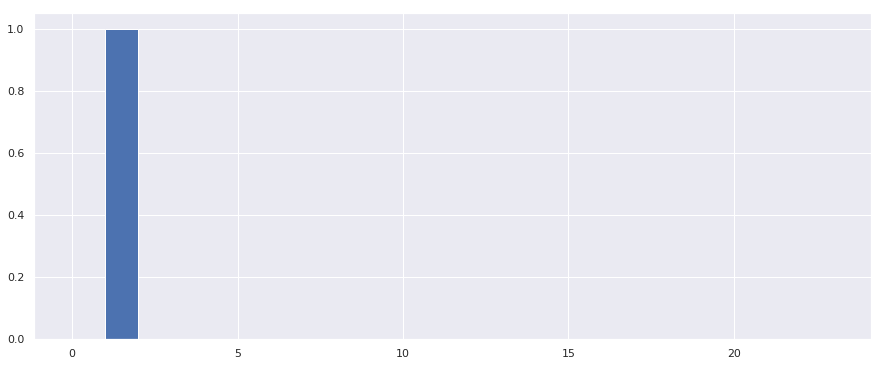

In [13]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [14]:
multi_region_exposure_keys_df = multi_region_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_region_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-10-22,ES,2c058c86-ee30-e1ec-261b-9f2e41ddc421
0,2020-10-21,ES,b29996ae-320e-1728-0d6a-5988db3eefca
1,2020-10-21,ES,e86045cc-038e-4087-a8e2-dbafb70dccad
2,2020-10-21,ES,84f5f784-4a1c-ad30-79b7-4ba6ddacc952
3,2020-10-21,ES,2fc6e472-13e8-d7ba-3ecd-603964ef35cd


In [15]:
active_regions = \
    multi_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['IT-IT', 'ES@PRE', 'PT', 'ES', 'BE', 'IT', 'CH']

In [16]:
multi_region_summary_df = multi_region_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_region_summary_df.rename_axis("sample_date", inplace=True)
multi_region_summary_df = multi_region_summary_df.fillna(0).astype(int)
multi_region_summary_df = multi_region_summary_df.head(backend_generation_days)
multi_region_summary_df.head()

shared_teks_by_generation_date                                  
region                                  BE    CH   ES ES@PRE   IT IT-IT   PT
sample_date                                                                 
2020-10-22                               0     0    1      0    0     0    0
2020-10-21                               0   228  170     10    0     0   22
2020-10-20                             370   768  306     12  118     0   61
2020-10-19                             597  1230  417     58  665    76  103
2020-10-18                             678  1600  512     65  652    61  155

In [17]:
multi_region_without_active_region_exposure_keys_df = \
    multi_region_exposure_keys_df[multi_region_exposure_keys_df.region != active_region_country_code]
multi_region_without_active_region = \
    multi_region_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_region_without_active_region

['IT-IT', 'ES@PRE', 'PT', 'BE', 'IT', 'CH']

In [18]:
exposure_keys_summary_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.region == active_region_country_code]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-10-22,1
2020-10-21,170
2020-10-20,306
2020-10-19,417
2020-10-18,512


### Dump API TEKs

In [19]:
tek_list_df = multi_region_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-09,BE,"[01f2109d-f69d-2976-27b3-58e628713ba2, 026167c...",2020-10-22,2020-10-22@02
1,2020-10-09,CH,"[19024ac2-96a4-e58a-633c-c2c7272fa6ed, 1cd79c0...",2020-10-22,2020-10-22@02
2,2020-10-09,ES,"[c419bf5f-abd7-6de7-b15a-ed08846f6659, 653fc50...",2020-10-22,2020-10-22@02
3,2020-10-09,ES@PRE,"[55467036-5455-3669-5a6c-535672793751, 6656704...",2020-10-22,2020-10-22@02
4,2020-10-09,IT,"[d8169578-1638-4b4d-e30d-31e3e1d96108, ec094f6...",2020-10-22,2020-10-22@02


### Load TEK Dumps

In [20]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [21]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=active_region_country_code,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
2,ES,2020-10-09,"[c419bf5f-abd7-6de7-b15a-ed08846f6659, 653fc50...",2020-10-22,NaN
9,ES,2020-10-10,"[ef4d8b05-19d9-b762-1406-648d53c0d55a, e4bc52f...",2020-10-22,NaN
16,ES,2020-10-11,"[1c1efc7c-a5f0-083b-7f73-7a2e1115d731, d2a73d0...",2020-10-22,NaN
23,ES,2020-10-12,"[396dca37-ed41-dd80-22be-eeb23d71c8da, 99d8402...",2020-10-22,NaN
30,ES,2020-10-13,"[ffba50a8-7b01-122e-2363-426867808db1, 932381e...",2020-10-22,NaN


In [22]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-22,1
2020-10-21,170
2020-10-20,306
2020-10-19,417
2020-10-18,512


### Daily New TEKs

In [23]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{af214518-3c22-fd44-f885-207eafa69183, 8647bd9..."
2020-08-30,"{af214518-3c22-fd44-f885-207eafa69183, 8647bd9..."
2020-08-31,"{af214518-3c22-fd44-f885-207eafa69183, 8647bd9..."
2020-09-01,"{af214518-3c22-fd44-f885-207eafa69183, 8647bd9..."
2020-09-02,"{af214518-3c22-fd44-f885-207eafa69183, 8647bd9..."


In [24]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-24-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [25]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
37,2020-10-22,2020-10-14,1,8
30,2020-10-22,2020-10-13,1,9
23,2020-10-22,2020-10-12,1,10
16,2020-10-22,2020-10-11,1,11
9,2020-10-22,2020-10-10,1,12


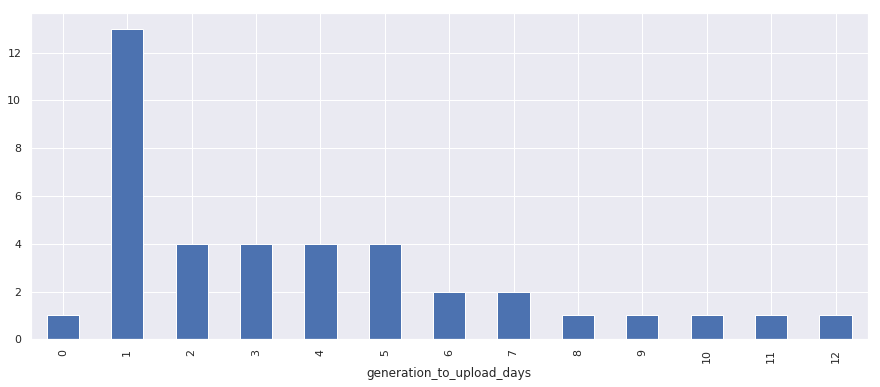

In [26]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [27]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-10-22,1,13,4,4,4,4,2,2,1,1,1,1,1,0
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2
2020-10-19,142,123,118,105,86,72,45,33,22,17,12,9,4,3
2020-10-18,146,132,114,96,87,54,33,18,12,10,9,7,5,3


In [28]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
50,2020-10-18,726.0
51,2020-10-19,791.0
52,2020-10-20,772.0
53,2020-10-21,841.0
54,2020-10-22,39.0


In [29]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
2,ES,2020-10-09,"[c419bf5f-abd7-6de7-b15a-ed08846f6659, 653fc50...",2020-10-22,NaN,2020-10-10
9,ES,2020-10-10,"[ef4d8b05-19d9-b762-1406-648d53c0d55a, e4bc52f...",2020-10-22,NaN,2020-10-11
16,ES,2020-10-11,"[1c1efc7c-a5f0-083b-7f73-7a2e1115d731, d2a73d0...",2020-10-22,NaN,2020-10-12
23,ES,2020-10-12,"[396dca37-ed41-dd80-22be-eeb23d71c8da, 99d8402...",2020-10-22,NaN,2020-10-13
30,ES,2020-10-13,"[ffba50a8-7b01-122e-2363-426867808db1, 932381e...",2020-10-22,NaN,2020-10-14


In [30]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
87,2020-10-22,[2c058c86-ee30-e1ec-261b-9f2e41ddc421]
90,2020-10-21,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."
78,2020-10-20,"[97b27565-a475-f559-44f7-2b692ee719c3, a031a2f..."
78,2020-10-19,"[49c35d4b-f069-88fd-c596-f1e5dea1fc8b, b9dc5ad..."
116,2020-10-18,"[655818ea-7b68-5788-d4c5-eaf6aefc8780, 7be987d..."


In [31]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
87,2020-10-22,1
90,2020-10-21,157
78,2020-10-20,149
78,2020-10-19,142
116,2020-10-18,146


In [32]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
84,ES,2020-10-21,"[b29996ae-320e-1728-0d6a-5988db3eefca, e86045c...",2020-10-22,NaN,2020-10-22
85,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21
73,ES,2020-10-19,"[1c849f04-e59b-7f45-7e6b-e13356aec58b, 53ea152...",2020-10-20,NaN,2020-10-20
73,ES,2020-10-18,"[d1d49196-d84e-b08c-f0b0-766022303d56, b51293d...",2020-10-19,NaN,2020-10-19
110,ES,2020-10-17,"[6a7f4f73-937b-46ae-caa5-55ec962fd39b, 5de6c32...",2020-10-18,NaN,2020-10-18


In [33]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date,same_day_tek_list
0,ES,2020-10-21,"[b29996ae-320e-1728-0d6a-5988db3eefca, e86045c...",2020-10-22,NaN,2020-10-22,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."
1,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21,"[97b27565-a475-f559-44f7-2b692ee719c3, a031a2f..."
2,ES,2020-10-19,"[1c849f04-e59b-7f45-7e6b-e13356aec58b, 53ea152...",2020-10-20,NaN,2020-10-20,"[49c35d4b-f069-88fd-c596-f1e5dea1fc8b, b9dc5ad..."
3,ES,2020-10-18,"[d1d49196-d84e-b08c-f0b0-766022303d56, b51293d...",2020-10-19,NaN,2020-10-19,"[655818ea-7b68-5788-d4c5-eaf6aefc8780, 7be987d..."
4,ES,2020-10-17,"[6a7f4f73-937b-46ae-caa5-55ec962fd39b, 5de6c32...",2020-10-18,NaN,2020-10-18,"[a9e26e0b-d9eb-dab7-e470-13e1d3b974c9, 7ba307a..."


In [34]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
estimated_shared_diagnoses_df["sample_date_string"] = estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-10-22,13
1,2020-10-21,153
2,2020-10-20,135
3,2020-10-19,123
4,2020-10-18,132


### Hourly New TEKs

In [35]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=active_region_country_code, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
2,ES,2020-10-09,"[c419bf5f-abd7-6de7-b15a-ed08846f6659, 653fc50...",2020-10-22,2020-10-22@02
9,ES,2020-10-10,"[ef4d8b05-19d9-b762-1406-648d53c0d55a, e4bc52f...",2020-10-22,2020-10-22@02
16,ES,2020-10-11,"[1c1efc7c-a5f0-083b-7f73-7a2e1115d731, d2a73d0...",2020-10-22,2020-10-22@02
23,ES,2020-10-12,"[396dca37-ed41-dd80-22be-eeb23d71c8da, 99d8402...",2020-10-22,2020-10-22@02
30,ES,2020-10-13,"[ffba50a8-7b01-122e-2363-426867808db1, 932381e...",2020-10-22,2020-10-22@02


In [36]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-10-21@01,0
1,2020-10-21@02,9
2,2020-10-21@03,0
3,2020-10-21@04,5
4,2020-10-21@05,0


In [37]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["same_day_tek_list"] = \
    hourly_estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-10-21@01,0
1,2020-10-21@02,5
2,2020-10-21@03,0
3,2020-10-21@04,1
4,2020-10-21@05,0


In [38]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-10-21 02:00:00,2020-10-21@02,9,5
2020-10-21 03:00:00,2020-10-21@03,0,0
2020-10-21 04:00:00,2020-10-21@04,5,1
2020-10-21 05:00:00,2020-10-21@05,0,0
2020-10-21 06:00:00,2020-10-21@06,4,1


### Data Merge

In [39]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-10-22,1,39.0
1,2020-10-21,170,841.0
2,2020-10-20,306,772.0
3,2020-10-19,417,791.0
4,2020-10-18,512,726.0


In [40]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-10-22,1,39.0,1.0
1,2020-10-21,170,841.0,157.0
2,2020-10-20,306,772.0,149.0
3,2020-10-19,417,791.0,142.0
4,2020-10-18,512,726.0,146.0


In [41]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-10-22,1,39.0,1.0,13.0
1,2020-10-21,170,841.0,157.0,153.0
2,2020-10-20,306,772.0,149.0,135.0
3,2020-10-19,417,791.0,142.0,123.0
4,2020-10-18,512,726.0,146.0,132.0


In [42]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-07-31,288522.0,3092.0,2300,NaN,NaN,NaN,NaN
1,2020-08-01,288522.0,0.0,2300,NaN,NaN,NaN,NaN
2,2020-08-02,288522.0,0.0,2300,NaN,NaN,NaN,NaN
3,2020-08-03,297054.0,8532.0,3519,NaN,NaN,NaN,NaN
4,2020-08-04,302814.0,5760.0,3172,NaN,NaN,NaN,NaN


In [43]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,,
2020-10-22,1019186.0,13891.0,13891,1.0,39.0,1.0,13.0
2020-10-21,1005295.0,16973.0,13891,170.0,841.0,157.0,153.0
2020-10-20,988322.0,13873.0,13177,306.0,772.0,149.0,135.0
2020-10-19,974449.0,37889.0,12212,417.0,791.0,142.0,123.0
2020-10-18,936560.0,0.0,10778,512.0,726.0,146.0,132.0


In [44]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,,
2020-10-22,1019186,13891,13891,1,39,1,13,3.000000,0.000936
2020-10-21,1005295,16973,13891,170,841,157,153,5.496732,0.011014
2020-10-20,988322,13873,13177,306,772,149,135,5.718519,0.010245
2020-10-19,974449,37889,12212,417,791,142,123,6.430894,0.010072
2020-10-18,936560,0,10778,512,726,146,132,5.500000,0.012247
2020-10-17,936560,0,10778,631,767,174,138,5.557971,0.012804
2020-10-16,936560,15186,10778,649,769,149,141,5.453901,0.013082
2020-10-15,921374,13318,10436,687,671,151,175,3.834286,0.016769
2020-10-14,908056,11970,10308,644,463,1,133,3.481203,0.012903


In [45]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-10-22,85505,2686,4705,835,5.634731,0.009766
2020-10-21,82050,3372,5337,997,5.353059,0.012151
2020-10-20,78467,3846,4959,977,5.075742,0.012451
2020-10-19,75387,4114,4521,954,4.738994,0.012655
2020-10-18,73969,4218,4056,967,4.194416,0.013073


In [46]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[0]
last_7_days_summary

{'covid_cases': 85505,
 'shared_teks_by_generation_date': 2686,
 'shared_teks_by_upload_date': 4705,
 'shared_diagnoses': 835,
 'teks_per_shared_diagnosis': 5.634730538922156,
 'shared_diagnoses_per_covid_case': 0.009765510788842758}

## Report Results

In [47]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend Region",
    "covid_cases": "COVID-19 Cases (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [48]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [49]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-10-22,13891,1,39,1,13,3.000000,0.000936
2020-10-21,13891,170,841,157,153,5.496732,0.011014
2020-10-20,13177,306,772,149,135,5.718519,0.010245
2020-10-19,12212,417,791,142,123,6.430894,0.010072
2020-10-18,10778,512,726,146,132,5.500000,0.012247
...,...,...,...,...,...,...,...
2020-08-04,3172,0,0,0,0,0.000000,0.000000
2020-08-03,3519,0,0,0,0,0.000000,0.000000
2020-08-02,2300,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

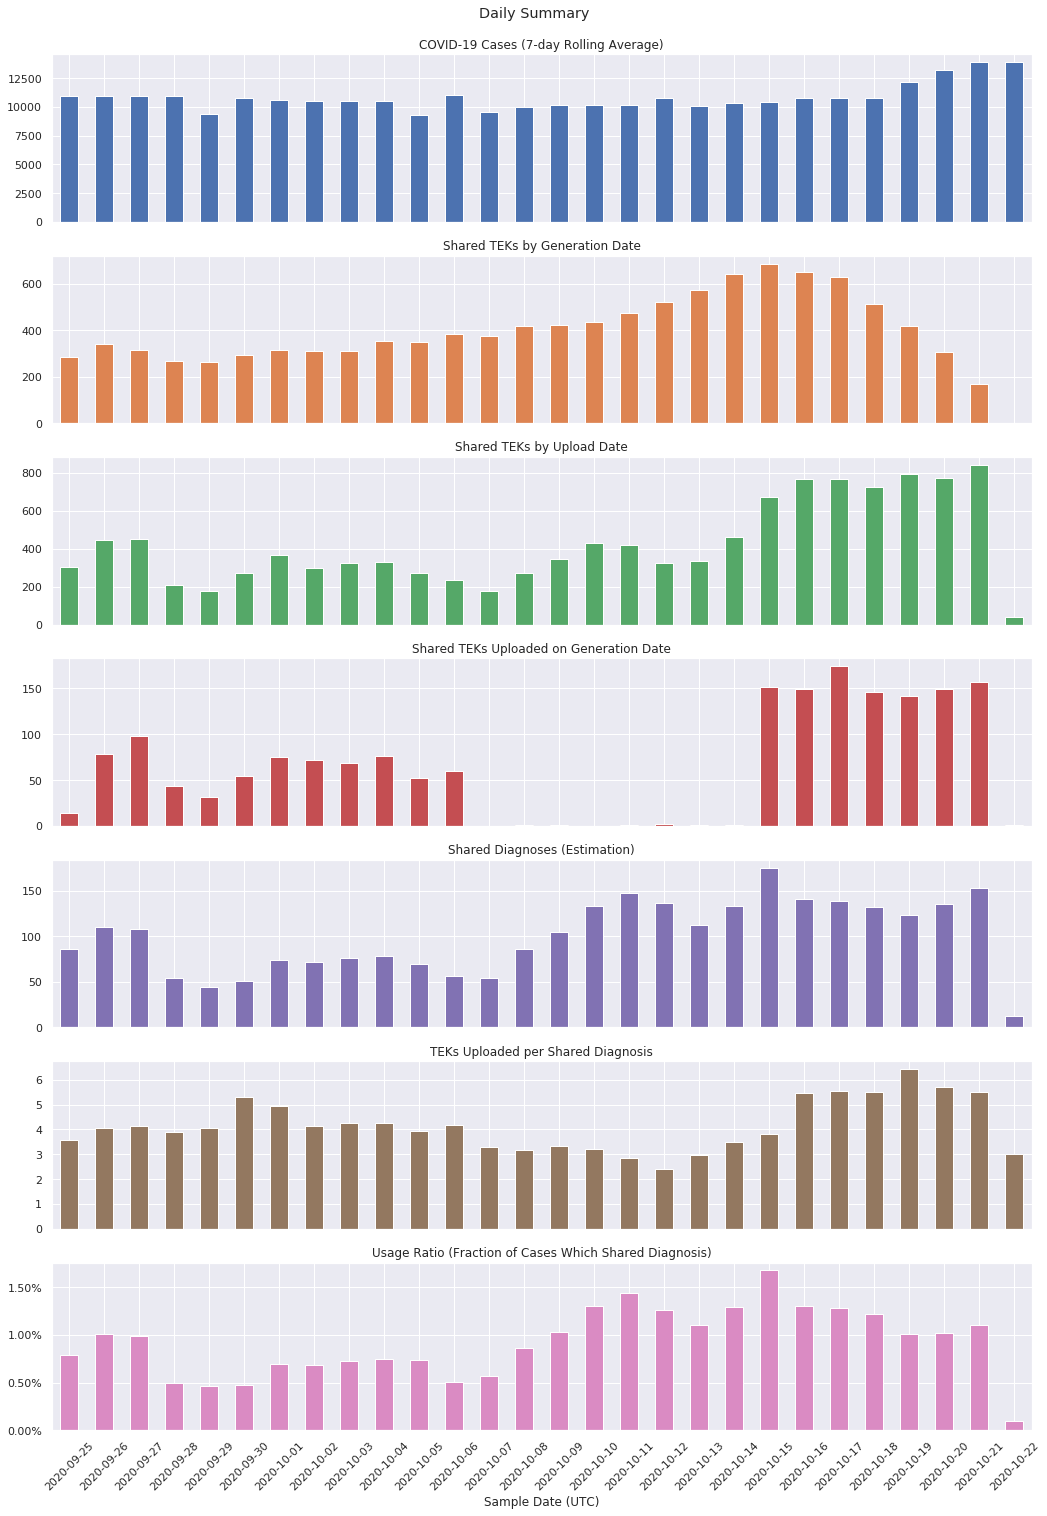

In [50]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [51]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-10-22,1,13,4,4,4,4,2,2,1,1,1,1,1,0
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2
2020-10-19,142,123,118,105,86,72,45,33,22,17,12,9,4,3
2020-10-18,146,132,114,96,87,54,33,18,12,10,9,7,5,3
2020-10-17,174,138,118,108,84,54,32,19,15,11,7,4,2,1
2020-10-16,149,141,125,107,84,53,32,24,20,15,7,5,3,4
2020-10-15,151,175,104,86,58,38,23,14,8,6,4,2,1,1
2020-10-14,1,133,80,69,54,38,30,24,14,9,6,3,1,1


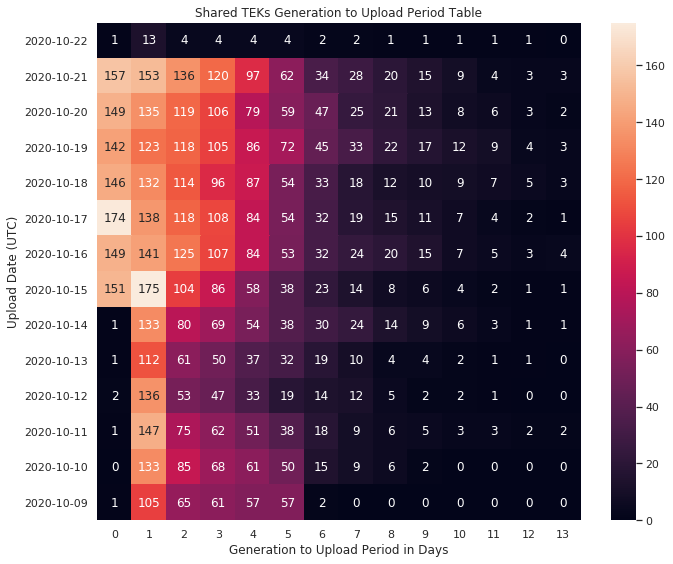

In [52]:
import matplotlib.pyplot as plt

fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(10, 1 + 0.5 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

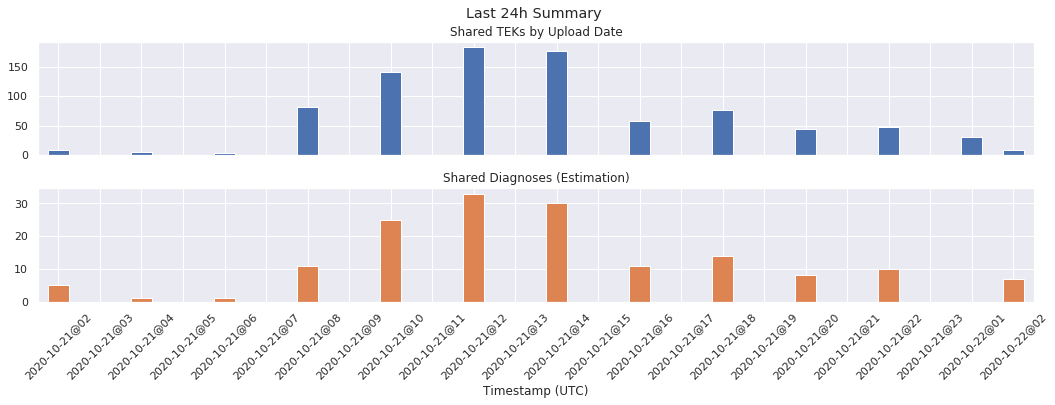

In [53]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [54]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [55]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_region_summary_table_html = multi_region_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

In [56]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_region_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [57]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_region_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_region_summary_table_image_path,
    report_resources_path_prefix + "Multi-Region-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [58]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [59]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_region_summary_table_html=multi_region_summary_table_html)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [60]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    status = textwrap.dedent(f"""
        #RadarCOVID Report – {extraction_date_with_hour}

        Today:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - TEKs per Diagnosis: ≥{teks_per_shared_diagnosis:.1f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Week:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        More Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)